In [39]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

import sklearn

import requests
import json

import matplotlib.pyplot as plt
import mplcyberpunk
from matplotlib import rc
import seaborn as sns

plt.style.use('cyberpunk')

plt.rcParams['axes.unicode_minus'] = False
rc('font', family='AppleGothic')

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings(action='ignore')

### Step 1. 데이터 수집 및 전처리

1-1. Fred api - gpd, interest, dept

In [17]:
from fredapi import Fred
import os

# FRED API 호출
FRED_API_KEY = os.getenv('FRED_API_KEY')
fred = Fred(api_key=FRED_API_KEY)
start_date = '1980-01-01'
end_date = '2024-12-31'

# 부채사이클
interest_payments = fred.get_series("A091RC1Q027SBEA") #Billions of Dollars
gdp = fred.get_series("GDP") #Billions of Dollars
dept = fred.get_series("GFDEBTN") #Millions of Dollars

# gdp 대비 이자비용
interest_payments_to_gdp = interest_payments / gdp
# gdp 대비 부채
dept_to_gdp = dept / gdp / 1000


# 통화량
m0 = fred.get_series("BOGMBASE") # M0
m1 = fred.get_series("M1SL") # M1
m1_to_m0 = m1 / m0 

1-2. coinmarketcap - bitcoin price, supply, market cap

In [4]:
url = "https://api.coinmarketcap.com/data-api/v3/cryptocurrency/detail/chart?id=1&timeStart=1633910400&timeEnd=1704931200"
res = requests.get(url)
bitcoin_price = res.json()['data']['points']
data_bitcoin_mc = {datetime.fromtimestamp(int(k)):v['v'] for k,v in bitcoin_price.items()}
df_bitcoin_mc =pd.DataFrame(index=data_bitcoin_mc.keys(), data=data_bitcoin_mc.values(), columns=['price', 'volume', 'market_cap','-','supply'])
df_bitcoin_mc

,price,volume,market_cap,-,supply
2010-07-14 09:00:00,0.058157,2.615400e+02,1.961800e+05,1.0,3373269.0
2010-07-22 09:00:00,0.074179,2.167060e+03,2.584294e+05,1.0,3483875.0
2010-07-30 09:00:00,0.063739,3.013580e+03,2.269748e+05,1.0,3561029.0
2010-08-06 09:00:00,0.060768,1.397310e+03,2.210160e+05,1.0,3637025.0
2010-08-14 09:00:00,0.062908,4.404590e+03,2.340858e+05,1.0,3721075.0
...,...,...,...,...,...
2024-12-05 09:00:00,98741.539382,1.492189e+11,1.954290e+12,1.0,19791975.0
2024-12-13 09:00:00,100046.650538,5.689475e+10,1.980461e+12,1.0,19795372.0
2024-12-20 09:00:00,97484.697310,1.056341e+11,1.930089e+12,1.0,19798896.0
2024-12-28 09:00:00,94160.186223,2.410744e+10,1.864805e+12,1.0,19804607.0


1-3. world gold council - gold price, mine production, mine total

In [8]:
url = 'https://fsapi.gold.org/api/v11/charts/supply-and-demand/35'
res = requests.get(url)
data_gld_mc = res.json()['chartData']['Supply_Quarterly']
df_gld_mc = pd.DataFrame({
    'date':data_gld_mc['categories'],
    'mine_production':data_gld_mc['series'][0]['data'],
    'price/oz': data_gld_mc['series'][-1]['data']
})
df_gld_mc['date'] = df_gld_mc['date'].apply(lambda x : '20'+x[-2:]+x[:2])
df_gld_mc['date'] = df_gld_mc['date'].apply(lambda x : pd.Period(x, freq='Q').to_timestamp())
df_gld_mc = df_gld_mc.set_index('date')
df_gld_mc.head()

,mine_production,price/oz
date,,
2010-01-01,632.000,1109.1
2010-04-01,674.598,1196.7
2010-07-01,729.703,1226.8
2010-10-01,718.165,1366.8
2011-01-01,667.553,1386.3


25.1 기준,
- 1t은 35274oz
- 연간 채굴량 약 3600t(분기별 900t)
- oz로 환산하면 연간 1,269,842,400oz, 분기별 31,746,600oz
- 현재(25.1.3 기준) 금은 온스(oz)당 2,634$
- 현재(25 기준) 총 금 채굴량 201,296t, 온스로 환산하면 7,100,515,104
- 시가총액은 18,702,756,783,936$  (18 trillion dollar)


In [9]:
data_gld_prod = requests.get('https://api.ourworldindata.org/v1/indicators/66252.data.json').json()
data_gld_prod_values = data_gld_prod['values']
data_gld_prod_entities = data_gld_prod['entities']
data_gld_prod_years = data_gld_prod['years']
print(len(data_gld_prod_values), len(data_gld_prod_entities), len(data_gld_prod_years))
df_gld_prod = pd.DataFrame(data={
    'years':data_gld_prod_years,
    'entities': data_gld_prod_entities, 
    'values': data_gld_prod_values})
df_gld_prod.head()

36478 36478 36478


,years,entities,values
0,1681,153,0
1,1681,155,0
2,1681,157,0
3,1681,159,0
4,1681,160,0


- https://ourworldindata.org/grapher/gold-production

In [11]:
df_gld_prod_total = (df_gld_prod.groupby('years').agg('sum')/2).cumsum().loc[2009]['values']
df_gld_mc['mine_total'] = df_gld_mc['mine_production'].cumsum() + df_gld_prod_total
df_gld_mc.head()

,mine_production,price/oz,mine_total
date,,,
2010-01-01,632.000,1109.1,143529.000
2010-04-01,674.598,1196.7,144203.598
2010-07-01,729.703,1226.8,144933.301
2010-10-01,718.165,1366.8,145651.466
2011-01-01,667.553,1386.3,146319.019


In [13]:
oz_to_ton = 35274
df_gld_mc['market_cap'] = df_gld_mc['price/oz']*df_gld_mc['mine_total']*oz_to_ton
df_gld_mc.head()

,mine_production,price/oz,mine_total,market_cap
date,,,,
2010-01-01,632.000,1109.1,143529.000,5.615198e+12
2010-04-01,674.598,1196.7,144203.598,6.087179e+12
2010-07-01,729.703,1226.8,144933.301,6.271864e+12
2010-10-01,718.165,1366.8,145651.466,7.022222e+12
2011-01-01,667.553,1386.3,146319.019,7.155051e+12


### Step 2. GDP 대비 부채율, 이자비용 기반 부채 사이클 분석

variables
- gdp
- dept
- interest_payments
- interest_payments_to_gdp
- dept_to_gdp
- m0
- m1
- m1_to_m0
- df_bitcoin_mc
- df_gld_mc

In [36]:
for k,(kk,v) in enumerate(var_dict.items()):
    print(kk)

gdp
dept
interest_payments
interest_payments_to_gdp
dept_to_gdp


In [55]:
np.log(gdp).diff()

1946-01-01         NaN
1946-04-01         NaN
1946-07-01         NaN
1946-10-01         NaN
1947-01-01         NaN
                ...   
2023-07-01    0.018545
2023-10-01    0.011704
2024-01-01    0.011493
2024-04-01    0.013624
2024-07-01    0.012269
Length: 315, dtype: float64

In [78]:
var_dict.keys()

dict_keys(['gdp', 'dept', 'dept_to_gdp', 'interest_payments', 'interest_payments_to_gdp'])

In [89]:
[print(f'[{k}] before_startdate:{x.index[0].date()}, before_enddate:{x.index[-1].date()}') for k,x in var_dict.items()]
date_li = [{x.index[0].date(), x.index[-1].date()} for x in var_dict.values()]
start_date_max = max(start for start,end in date_li)
end_date_min = min(end for start,end in date_li)
print(f'>>[intersection] after_startdate:{start_date_max}, after_enddate:{end_date_min}')



[gdp] before_startdate:1966-01-01, before_enddate:2024-07-01
[dept] before_startdate:1966-01-01, before_enddate:2024-07-01
[dept_to_gdp] before_startdate:1966-01-01, before_enddate:2024-07-01
[interest_payments] before_startdate:1966-01-01, before_enddate:2024-07-01
[interest_payments_to_gdp] before_startdate:1966-01-01, before_enddate:2024-07-01
>>[intersection] after_startdate:1966-01-01, after_enddate:2024-07-01


[gdp] before_startdate:1946-01-01, before_enddate:2024-07-01
[dept] before_startdate:1966-01-01, before_enddate:2024-07-01
[dept_to_gdp] before_startdate:1946-01-01, before_enddate:2024-07-01
[interest_payments] before_startdate:1947-01-01, before_enddate:2024-07-01
[interest_payments_to_gdp] before_startdate:1946-01-01, before_enddate:2024-07-01
>>[intersection] after_startdate:1966-01-01, after_enddate:2024-07-01


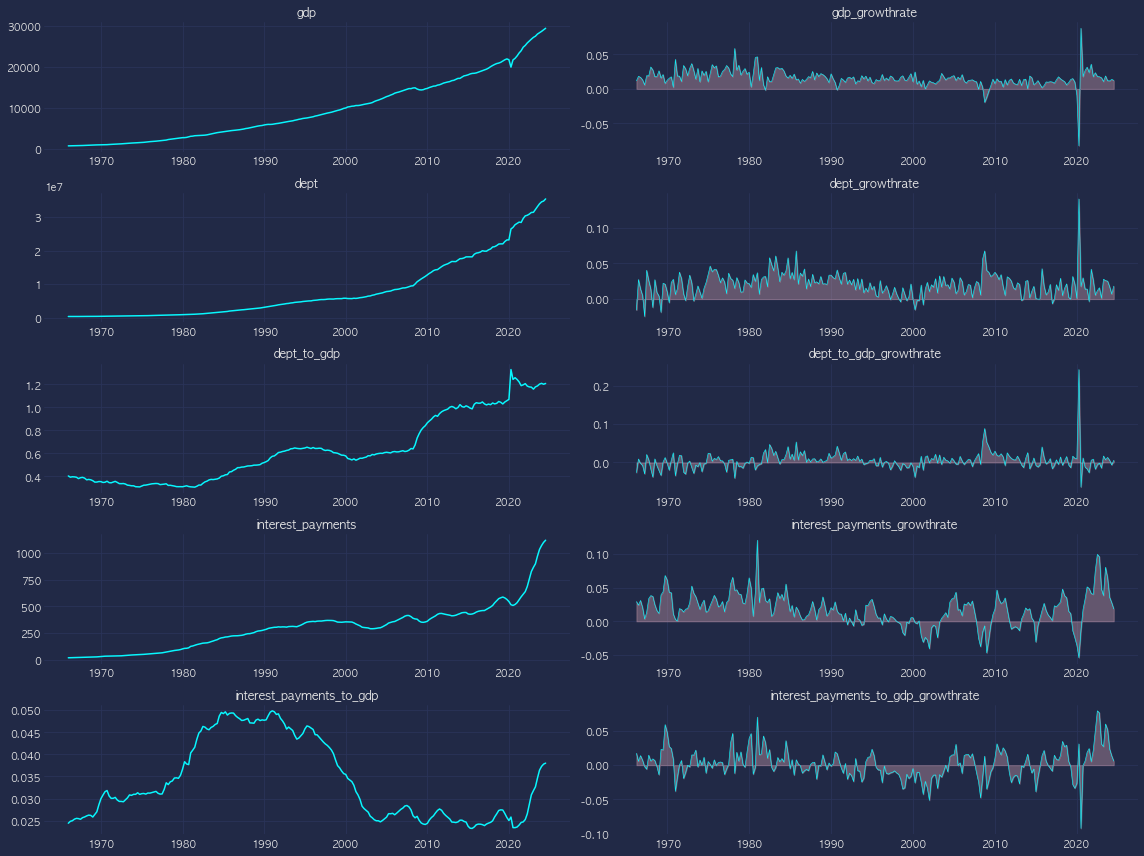

In [94]:
var_dict = {
    'gdp': gdp,
    'dept': dept,
    'dept_to_gdp': dept_to_gdp,
    'interest_payments': interest_payments,
    'interest_payments_to_gdp': interest_payments_to_gdp
}

[print(f'[{k}] before_startdate:{x.index[0].date()}, before_enddate:{x.index[-1].date()}') for k,x in var_dict.items()]
date_li = [{x.index[0].date(), x.index[-1].date()} for x in var_dict.values()]
start_date_max = max(start for start,end in date_li)
end_date_min = min(end for start,end in date_li)
print(f'>>[intersection] after_startdate:{start_date_max}, after_enddate:{end_date_min}')

for k,v in var_dict.items():
    var_dict[k] = var_dict[k][start_date_max:end_date_min]

var_gr_dict = {
    'gdp_growthrate': var_dict['gdp'].pct_change(),
    'dept_growthrate': var_dict['dept'].pct_change(),
    'dept_to_gdp_growthrate': var_dict['dept_to_gdp'].pct_change(),
    'interest_payments_growthrate': var_dict['interest_payments'].pct_change(),
    'interest_payments_to_gdp_growthrate': var_dict['interest_payments_to_gdp'].pct_change()
}

fig, axes = plt.subplots(nrows=len(var_dict.keys()), ncols=2, figsize=(16,12))


for i, (k,v) in enumerate(var_dict.items()):
    sns.lineplot(data=v,
                 x=v.index,
                 y=v.values,
                 ax=axes[i,0])
    axes[i,0].set_title(k)

for i, (k,v) in enumerate(var_gr_dict.items()):
    sns.lineplot(data=v,
                 x=v.index,
                 y=v.values,
                 ax=axes[i,1], linewidth=0.6)
    axes[i,1].fill_between(data=v, x=v.index, y1=0, y2=v.values, alpha=0.3, color='pink')
    axes[i,1].set_title(k)
    

plt.tight_layout()
plt.show()

In [118]:
var_dict['gdp']['1973Q1']

1973-01-01    1377.49
dtype: float64

In [237]:
date_li_expansion =  [
    # 1960s 황금기
    "1966", "1967", "1968", "1969",
    
    # 1980s 레이거노믹스 호황
    "1983", "1984", "1985", "1986", "1987", "1988", "1989",
    "1990Q1", "1990Q2",
    
    # 1990s 닷컴 호황
    "1991", "1992", "1993", "1994", "1995", "1996", "1997", "1998", "1999", "2000",
    "2001Q1",
    
    # 2009Q3 ~ 2020 경기 회복
    "2009Q3", "2009Q4",
    "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019",
    "2020Q1",
    
    # 2010 코로나 이후 양적완화 호황
    "2021"
]

date_li_recession = [
    # 1973Q4 ~ 1975Q1 오일 쇼크 불황
    "1973Q4", "1974", "1975Q1",
    
    # 1980Q1 ~ 1980Q2 연준 인플레 억제 정체 - 금리 상승, 경기 침체
    "1980Q1", "1980Q2", "1981Q3", "1981Q4", "1982",
    
    # 1990Q3 ~ 1991Q1 걸프전, 유가 상승
    "1990Q3", "1990Q4", "1991Q1",
    
    # 2001 닷컴 버블 붕괴, 9/11 테러
    "2001",
    
    # 2007Q4 ~ 2009Q2 글로벌 금융 위기(서브프라임 모기지)
    "2008", "2009Q1", "2009Q2",
    
    # 2020Q1 코로나19, 경제 봉쇄
    "2020Q1", "2020Q2" 
]

In [238]:
df_cycle = pd.DataFrame(index=var_dict['gdp'].index, 
                        data={'label':[np.nan]*len(var_dict['gdp'].index)})
df_cycle[date_li_expansion] = 1
df_cycle[date_li_recession] = -1
df_cycle = df_cycle.fillna(0)
df_cycle = df_cycle.astype('int64')
print(df_cycle.value_counts())
df_cycle

label
 1       131
 0        75
-1        29
dtype: int64


,label
1966-01-01,1
1966-04-01,1
1966-07-01,1
1966-10-01,1
1967-01-01,1
...,...
2023-07-01,0
2023-10-01,0
2024-01-01,0
2024-04-01,0


In [210]:
v

1966-01-01         NaN
1966-04-01    0.011621
1966-07-01    0.018208
1966-10-01    0.016671
1967-01-01    0.013042
                ...   
2023-07-01    0.018718
2023-10-01    0.011773
2024-01-01    0.011560
2024-04-01    0.013717
2024-07-01    0.012345
Length: 235, dtype: float64

In [217]:
v['1966-01']

1966-01-01   NaN
dtype: float64

In [218]:
v[str(date.date())[:-3]]

1966-01-01   NaN
dtype: float64

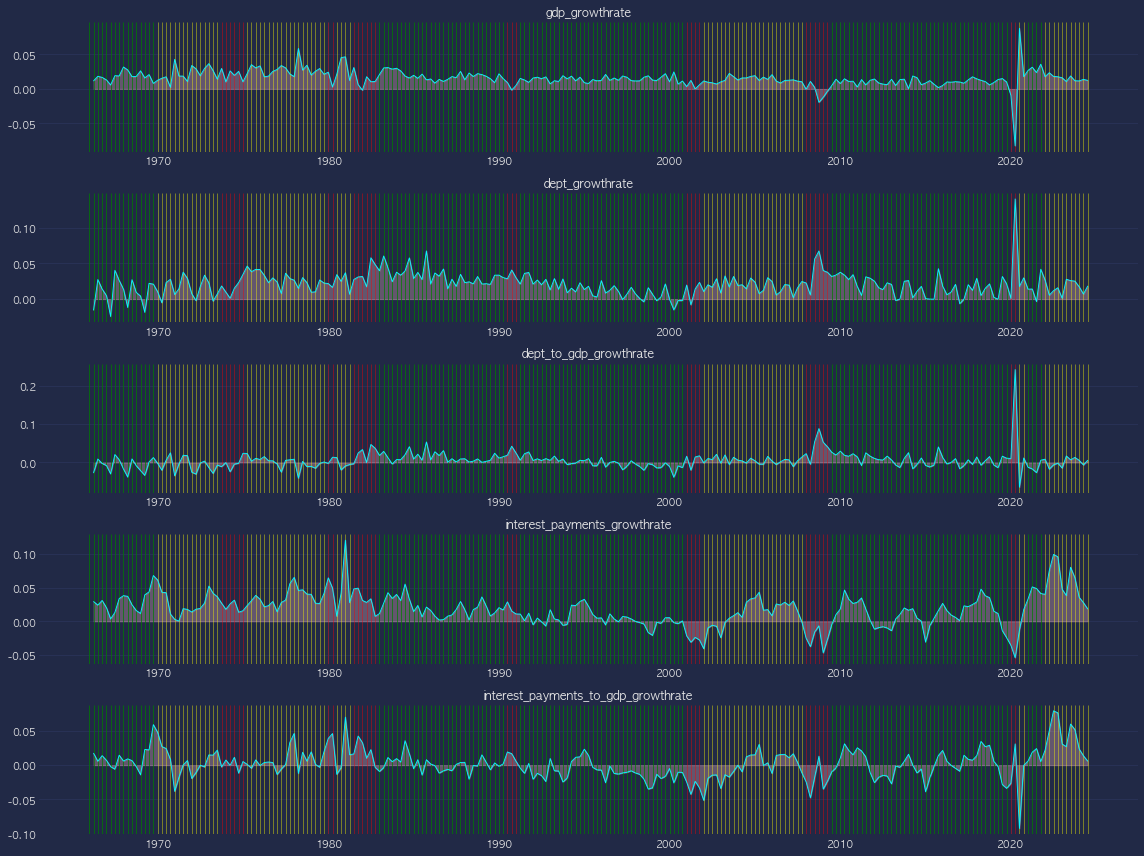

In [239]:
cmap = {
    '1': ['green',0.7],
    '-1': ['red',0.4],
    '0': ['yellow',0.4]
}

fig, axes = plt.subplots(nrows=len(var_dict.keys()), ncols=1, figsize=(16,12))

for i, (k,v) in enumerate(var_gr_dict.items()):
    sns.lineplot(data=v,
                 x=v.index,
                 y=v.values,
                 ax=axes[i], linewidth=0.9)
    axes[i].fill_between(data=v, x=v.index, y1=0, y2=v.values, alpha=0.3, color='pink')
    axes[i].set_title(k)
    for date,label in df_cycle.iterrows():
        axes[i].axvspan(xmin=v[str(date.date())[:-3]].index[0], 
                        xmax=v[str(date.date())[:-3]].index[-1], 
                        color=cmap[str(label.values[0])][0], 
                        alpha=cmap[str(label.values[0])][1])
    
plt.tight_layout()
plt.show()

In [239]:
df_cycle = pd.DataFrame(index=var_gr_dict.index, data={'label':[np.nan]*len(v.index)})
df_cycle[date_li_expansion] = 2
df_cycle[date_li_recession] = 0
df_cycle = df_cycle.fillna(1)
df_cycle = df_cycle.astype('int64')
print(df_cycle.value_counts())
df_cycle

label
2        127
1         80
0         28
dtype: int64


,label
1966-01-01,2
1966-04-01,2
1966-07-01,2
1966-10-01,2
1967-01-01,2
...,...
2023-07-01,1
2023-10-01,1
2024-01-01,1
2024-04-01,1


In [135]:
v.index[0]

Timestamp('1966-01-01 00:00:00')

In [110]:
labels.shape

(235,)

ValueError: x and y must have same first dimension, but have shapes (235,) and (5,)

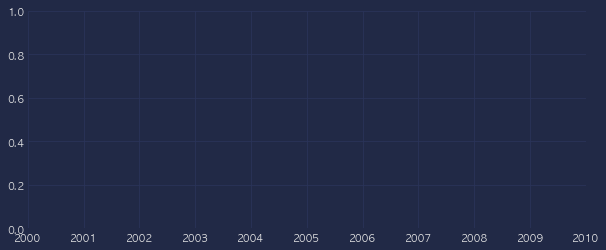

In [95]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Prepare data
data = np.stack([var_dict[k].values for k in var_dict.keys()], axis=1)
data_scaled = TimeSeriesScalerMeanVariance().fit_transform(data)

# Apply clustering
n_clusters = 3  # Number of clusters
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
labels = model.fit_predict(data_scaled)

# Visualize clusters
for cluster in range(n_clusters):
    plt.figure(figsize=(10, 4))
    for i, label in enumerate(labels):
        if label == cluster:
            plt.plot(var_dict['gdp'].index, data_scaled[i, :, 0], label=f"Series {i}")
    plt.title(f"Cluster {cluster}")
    plt.legend()
    plt.show()

### Step 3. 부채사이클별 M0, M1 통화 증가율과 금 가격간 인과 추론

### Step 4. 금, 비트코인 시가총액 시계열 연관성 분석

### Step 5. 미래 비트코인 시가총액 예측 및 현재 적정가 산출